# 🎯 ABC/XYZ Classification Analysis

This notebook performs comprehensive ABC/XYZ classification to segment inventory items based on:
- **ABC**: Revenue/value contribution (Pareto principle)
- **XYZ**: Demand variability (coefficient of variation)

## Objectives
1. Perform ABC classification (value-based)
2. Perform XYZ classification (variability-based)
3. Create combined ABC-XYZ matrix
4. Analyze characteristics of each class
5. Generate inventory policy recommendations

In [12]:
# Setup
import sys
from pathlib import Path

# Add project root to path
project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Import project modules
from src.inventory import ABCAnalyzer
from src.utils import load_config

# Configure display
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Setup complete!")

✅ Setup complete!


## 1. Load Data and Configuration

In [13]:
# Load configuration
config = load_config(project_root / 'config/config.yaml')

# Load processed demand statistics
demand_stats = pd.read_csv(project_root / 'data/processed/demand_statistics_ca1.csv')

print(f"Loaded {len(demand_stats)} items")
print(f"\nColumns: {demand_stats.columns.tolist()}")
demand_stats.head()

Loaded 3049 items

Columns: ['store_id', 'item_id', 'cat_id', 'sales_sum', 'sales_mean', 'sales_std', 'sales_min', 'sales_max', 'sales_count', 'revenue_sum', 'revenue_mean', 'sell_price_mean', 'sell_price_min', 'sell_price_max', 'demand_cv', 'fill_rate']


,store_id,item_id,cat_id,sales_sum,sales_mean,sales_std,sales_min,sales_max,sales_count,revenue_sum,revenue_mean,sell_price_mean,sell_price_min,sell_price_max,demand_cv,fill_rate
0,CA_1,FOODS_1_001,FOODS,290,0.641593,1.016426,0,7,452,649.60,1.437168,2.24,2.24,2.24,1.584223,0.398230
1,CA_1,FOODS_1_002,FOODS,193,0.426991,0.739435,0,4,452,1829.64,4.047876,9.48,9.48,9.48,1.731734,0.311947
2,CA_1,FOODS_1_003,FOODS,326,0.721239,1.146552,0,9,452,1052.98,2.329602,3.23,3.23,3.23,1.589698,0.420354
3,CA_1,FOODS_1_004,FOODS,4589,10.152655,8.920003,0,48,452,8994.44,19.899204,1.96,1.96,1.96,0.878588,0.780973
4,CA_1,FOODS_1_005,FOODS,486,1.075221,1.738722,0,24,452,1720.44,3.806283,3.54,3.54,3.54,1.617083,0.528761


## 2. ABC Analysis (Value-Based Classification)

In [14]:
# Initialize ABC analyzer
abc_analyzer = ABCAnalyzer(
    abc_thresholds=config['inventory']['abc_thresholds'],
    xyz_thresholds=config['inventory']['xyz_thresholds']
)

print(f"ABC thresholds: {config['inventory']['abc_thresholds']}")
print(f"XYZ thresholds: {config['inventory']['xyz_thresholds']}")

ABC thresholds: {'A': 0.8, 'B': 0.95, 'C': 1.0}
XYZ thresholds: {'X': 0.5, 'Y': 1.0, 'Z': 999}


In [15]:
# Perform ABC classification
abc_classified = abc_analyzer.perform_abc_analysis(
    demand_stats,
    value_col='revenue_sum'
)

print("\nABC Classification Results:")
print(abc_classified['abc_class'].value_counts().sort_index())

abc_classified[['item_id', 'revenue_sum', 'cumulative_pct', 'abc_class']].head(15)


ABC Classification Results:
abc_class
A    1253
B     932
C     864
Name: count, dtype: int64


,item_id,revenue_sum,cumulative_pct,abc_class
732,FOODS_3_120,91622.04,0.014599,A
1782,HOBBIES_1_354,65205.84,0.024988,A
1590,HOBBIES_1_158,44558.22,0.032088,A
1123,FOODS_3_511,36292.78,0.037871,A
702,FOODS_3_090,34083.40,0.043302,A
1198,FOODS_3_586,32457.60,0.048473,A
894,FOODS_3_282,31884.36,0.053554,A
1199,FOODS_3_587,30556.08,0.058423,A
814,FOODS_3_202,30042.42,0.063209,A
1579,HOBBIES_1_147,28515.37,0.067753,A


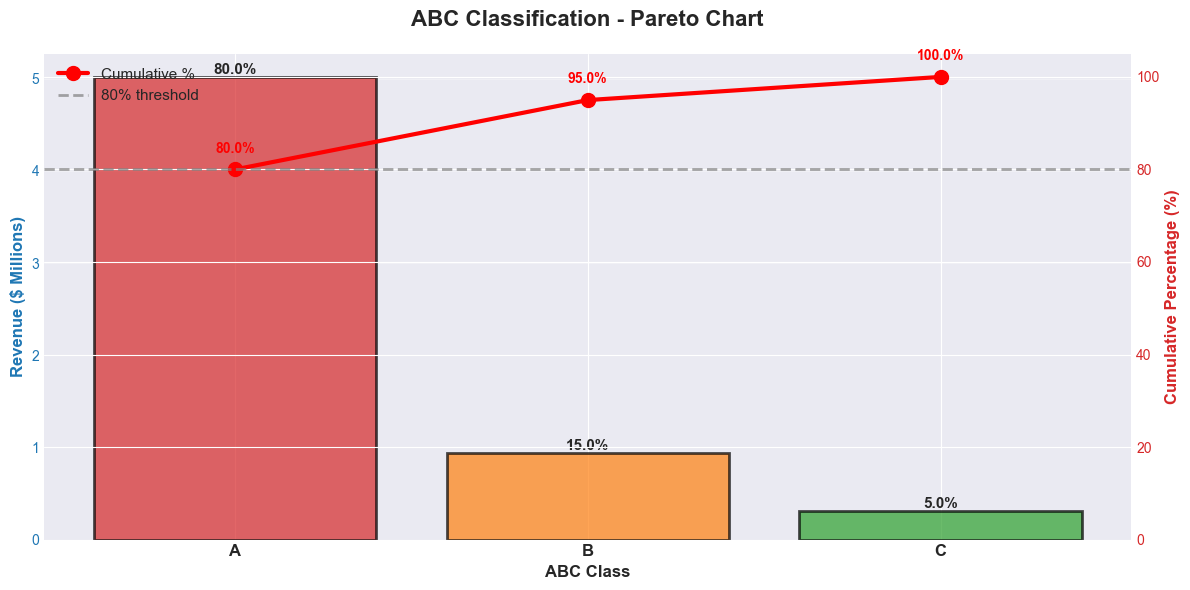


80-15-5 Rule Verification:
  Class A: 80.0% of revenue
  Class B: 15.0% of revenue
  Class C: 5.0% of revenue


In [16]:
# Pareto chart
abc_revenue = abc_classified.groupby('abc_class')['revenue_sum'].sum().sort_values(ascending=False)
abc_revenue_pct = (abc_revenue / abc_revenue.sum() * 100)
cumulative_pct = abc_revenue_pct.cumsum()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Bar chart
x = np.arange(len(abc_revenue))
colors = ['#d62728', '#ff7f0e', '#2ca02c']
bars = ax1.bar(x, abc_revenue / 1e6, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_xlabel('ABC Class', fontsize=12, fontweight='bold')
ax1.set_ylabel('Revenue ($ Millions)', fontsize=12, fontweight='bold', color='tab:blue')
ax1.set_title('ABC Classification - Pareto Chart', fontsize=16, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(abc_revenue.index, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for bar, pct in zip(bars, abc_revenue_pct):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Cumulative line
ax2 = ax1.twinx()
line = ax2.plot(x, cumulative_pct, 'ro-', linewidth=3, markersize=10, label='Cumulative %')
ax2.set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.set_ylim([0, 105])
ax2.axhline(y=80, color='gray', linestyle='--', alpha=0.7, linewidth=2, label='80% threshold')
ax2.legend(loc='upper left', fontsize=11)

# Add text annotations
for i, (x_pos, cum) in enumerate(zip(x, cumulative_pct)):
    ax2.text(x_pos, cum + 3, f'{cum:.1f}%', ha='center', va='bottom', 
            fontweight='bold', fontsize=10, color='red')

plt.tight_layout()
plt.show()

print("\n80-15-5 Rule Verification:")
for cls, pct in zip(abc_revenue.index, abc_revenue_pct):
    print(f"  Class {cls}: {pct:.1f}% of revenue")

## 3. XYZ Analysis (Variability-Based Classification)

In [17]:
# Perform XYZ classification
xyz_classified = abc_analyzer.perform_xyz_analysis(
    abc_classified,
    cv_col='demand_cv'
)

print("\nXYZ Classification Results:")
print(xyz_classified['xyz_class'].value_counts().sort_index())

# Show CV ranges for each class
for cls in ['X', 'Y', 'Z']:
    class_data = xyz_classified[xyz_classified['xyz_class'] == cls]
    if len(class_data) > 0:
        print(f"\nClass {cls}:")
        print(f"  CV range: {class_data['demand_cv'].min():.2f} - {class_data['demand_cv'].max():.2f}")
        print(f"  Mean CV: {class_data['demand_cv'].mean():.2f}")
        print(f"  Items: {len(class_data)}")


XYZ Classification Results:
xyz_class
X      22
Y     488
Z    2539
Name: count, dtype: int64

Class X:
  CV range: 0.00 - 0.50
  Mean CV: 0.37
  Items: 22

Class Y:
  CV range: 0.51 - 1.00
  Mean CV: 0.83
  Items: 488

Class Z:
  CV range: 1.00 - 21.26
  Mean CV: 1.94
  Items: 2539


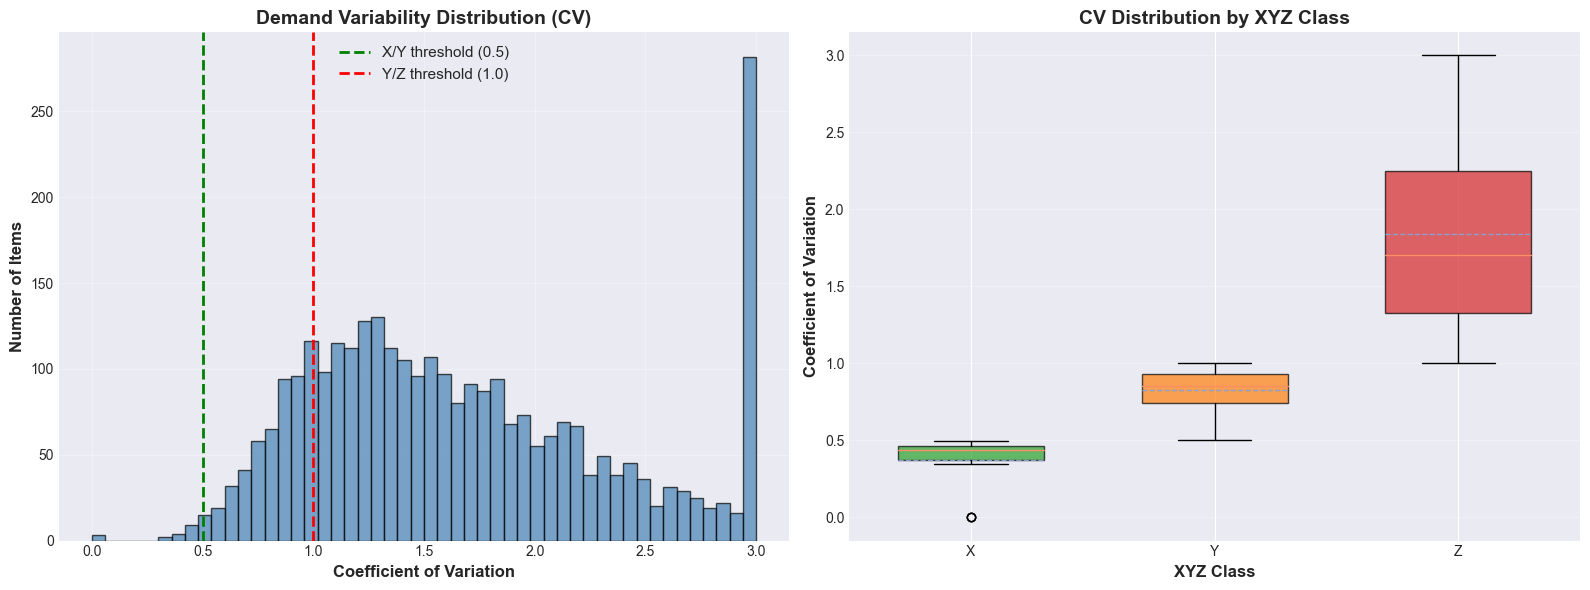

In [18]:
# CV distribution by XYZ class
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Histogram with class boundaries
axes[0].hist(xyz_classified['demand_cv'].clip(0, 3), bins=50, alpha=0.7, 
            color='steelblue', edgecolor='black')
axes[0].axvline(x=0.5, color='green', linestyle='--', linewidth=2, label='X/Y threshold (0.5)')
axes[0].axvline(x=1.0, color='red', linestyle='--', linewidth=2, label='Y/Z threshold (1.0)')
axes[0].set_xlabel('Coefficient of Variation', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Number of Items', fontsize=12, fontweight='bold')
axes[0].set_title('Demand Variability Distribution (CV)', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Boxplot by XYZ class
xyz_order = ['X', 'Y', 'Z']
colors = {'X': '#2ca02c', 'Y': '#ff7f0e', 'Z': '#d62728'}
box_data = [xyz_classified[xyz_classified['xyz_class'] == cls]['demand_cv'].clip(0, 3) 
            for cls in xyz_order if cls in xyz_classified['xyz_class'].values]
bp = axes[1].boxplot(box_data, labels=xyz_order, patch_artist=True, 
                     widths=0.6, showmeans=True, meanline=True)

for patch, color in zip(bp['boxes'], [colors[c] for c in xyz_order]):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1].set_xlabel('XYZ Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Coefficient of Variation', fontsize=12, fontweight='bold')
axes[1].set_title('CV Distribution by XYZ Class', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 4. Combined ABC-XYZ Analysis

In [19]:
# Perform combined analysis
combined = abc_analyzer.perform_combined_analysis(
    demand_stats,
    value_col='revenue_sum',
    cv_col='demand_cv'
)

print("Combined ABC-XYZ Classification Complete!")
print(f"\nTotal items: {len(combined)}")
print(f"Unique ABC-XYZ classes: {combined['abc_xyz_class'].nunique()}")

combined[['item_id', 'revenue_sum', 'demand_cv', 'abc_class', 'xyz_class', 
          'abc_xyz_class', 'priority_score']].head(20)

Combined ABC-XYZ Classification Complete!

Total items: 3049
Unique ABC-XYZ classes: 8


,item_id,revenue_sum,demand_cv,abc_class,xyz_class,abc_xyz_class,priority_score
732,FOODS_3_120,91622.04,0.649278,A,Y,AY,2
1782,HOBBIES_1_354,65205.84,0.541280,A,Y,AY,2
1590,HOBBIES_1_158,44558.22,0.657965,A,Y,AY,2
1123,FOODS_3_511,36292.78,1.046444,A,Z,AZ,3
702,FOODS_3_090,34083.40,0.740386,A,Y,AY,2
1198,FOODS_3_586,32457.60,0.346251,A,X,AX,1
894,FOODS_3_282,31884.36,0.594231,A,Y,AY,2
1199,FOODS_3_587,30556.08,0.359668,A,X,AX,1
814,FOODS_3_202,30042.42,0.720738,A,Y,AY,2
1579,HOBBIES_1_147,28515.37,0.637007,A,Y,AY,2


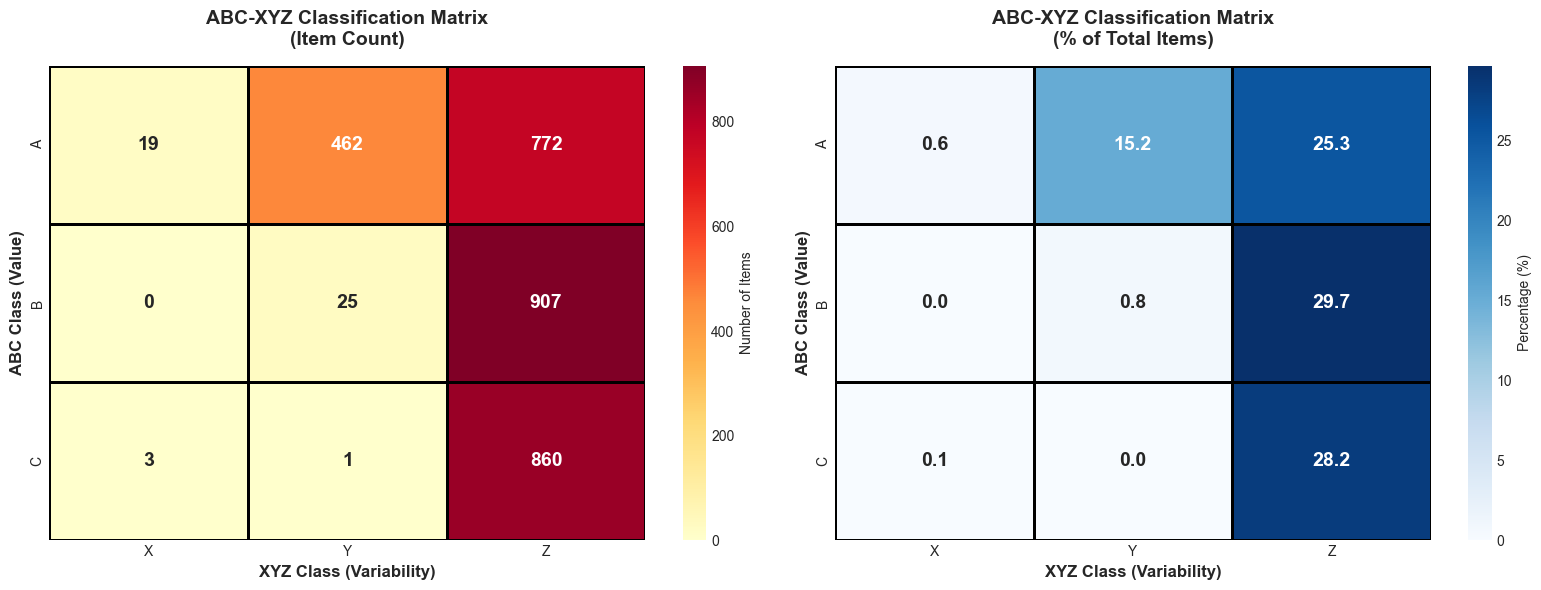


Matrix Summary:
xyz_class   X    Y    Z
abc_class              
A          19  462  772
B           0   25  907
C           3    1  860

Percentage Distribution:
xyz_class    X     Y     Z
abc_class                 
A          0.6  15.2  25.3
B          0.0   0.8  29.7
C          0.1   0.0  28.2


In [20]:
# ABC-XYZ Matrix
matrix = combined.groupby(['abc_class', 'xyz_class']).size().unstack(fill_value=0)
matrix_pct = (matrix / matrix.sum().sum() * 100).round(1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Count heatmap
sns.heatmap(matrix, annot=True, fmt='d', cmap='YlOrRd', ax=ax1, 
            cbar_kws={'label': 'Number of Items'}, linewidths=2, linecolor='black',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax1.set_title('ABC-XYZ Classification Matrix\n(Item Count)', 
             fontsize=14, fontweight='bold', pad=15)
ax1.set_xlabel('XYZ Class (Variability)', fontsize=12, fontweight='bold')
ax1.set_ylabel('ABC Class (Value)', fontsize=12, fontweight='bold')

# Percentage heatmap
sns.heatmap(matrix_pct, annot=True, fmt='.1f', cmap='Blues', ax=ax2,
            cbar_kws={'label': 'Percentage (%)'}, linewidths=2, linecolor='black',
            annot_kws={'fontsize': 14, 'fontweight': 'bold'})
ax2.set_title('ABC-XYZ Classification Matrix\n(% of Total Items)', 
             fontsize=14, fontweight='bold', pad=15)
ax2.set_xlabel('XYZ Class (Variability)', fontsize=12, fontweight='bold')
ax2.set_ylabel('ABC Class (Value)', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nMatrix Summary:")
print(matrix)
print("\nPercentage Distribution:")
print(matrix_pct)

## 5. Class Characteristics Analysis

In [21]:
# Get class statistics
class_stats = abc_analyzer.get_class_statistics(combined)

print("ABC-XYZ Class Statistics:")
print("=" * 100)
class_stats.sort_values('revenue_sum_sum', ascending=False)

ABC-XYZ Class Statistics:


,abc_xyz_class,revenue_sum_sum,revenue_sum_mean,revenue_sum_count,sales_sum_sum,sales_sum_mean,demand_cv_mean,fill_rate_mean,item_pct,revenue_pct
1,AY,2578757.84,5581.73,462,837775,1813.37,0.82,0.83,15.15,41.09
2,AZ,2152900.33,2788.73,772,499168,646.59,1.37,0.51,25.32,34.30
4,BZ,913374.67,1007.03,907,335550,369.96,1.69,0.39,29.75,14.55
7,CZ,313783.04,364.86,860,145468,169.15,2.71,0.20,28.21,5.00
0,AX,288491.01,15183.74,19,148280,7804.21,0.43,0.99,0.62,4.60
3,BY,28046.37,1121.85,25,19653,786.12,0.93,0.73,0.82,0.45
6,CY,650.87,650.87,1,671,671.00,0.94,0.72,0.03,0.01
5,CX,0.00,0.00,3,0,0.00,0.00,0.00,0.10,0.00


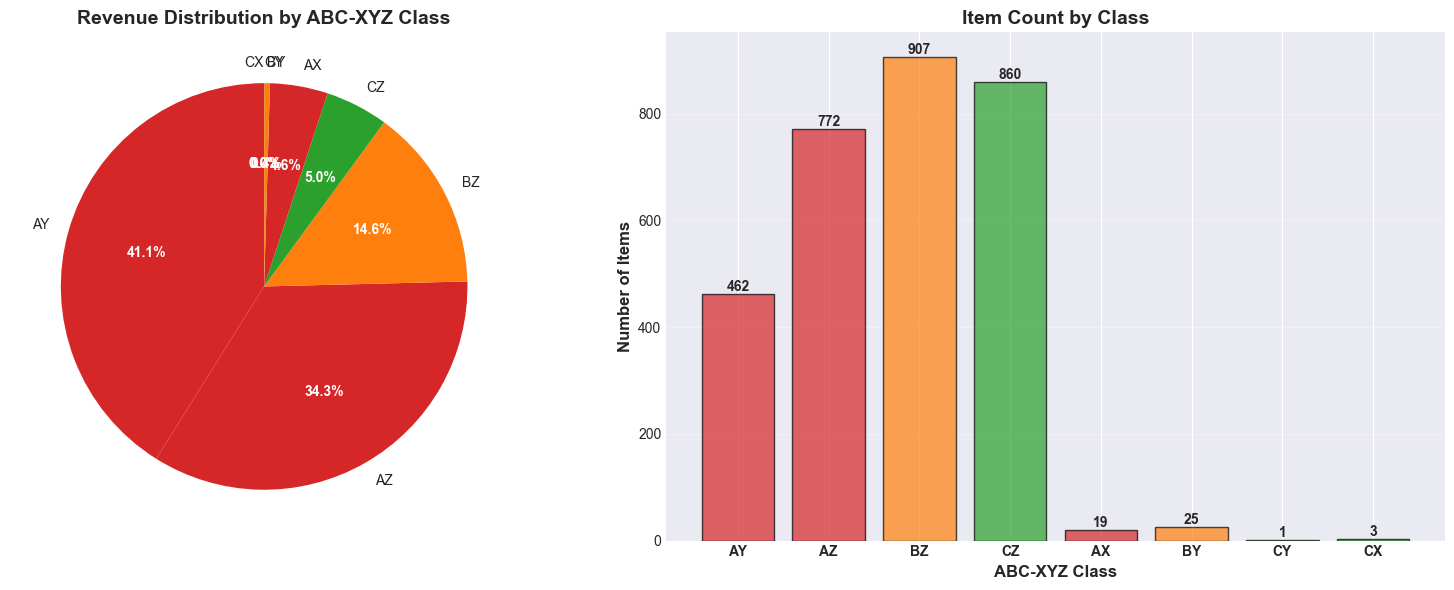

In [22]:
# Revenue concentration by class
top_classes = class_stats.nlargest(9, 'revenue_sum_sum')

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Revenue pie chart
colors_map = {
    'A': '#d62728', 'B': '#ff7f0e', 'C': '#2ca02c'
}
colors = [colors_map[cls[0]] for cls in top_classes['abc_xyz_class']]

wedges, texts, autotexts = axes[0].pie(top_classes['revenue_sum_sum'], 
                                        labels=top_classes['abc_xyz_class'],
                                        autopct='%1.1f%%', colors=colors,
                                        startangle=90, textprops={'fontsize': 10})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

axes[0].set_title('Revenue Distribution by ABC-XYZ Class', fontsize=14, fontweight='bold')

# Item count bar chart
x = np.arange(len(top_classes))
colors = [colors_map[cls[0]] for cls in top_classes['abc_xyz_class']]
bars = axes[1].bar(x, top_classes['revenue_sum_count'], color=colors, alpha=0.7, edgecolor='black')
axes[1].set_xticks(x)
axes[1].set_xticklabels(top_classes['abc_xyz_class'], rotation=0, fontweight='bold')
axes[1].set_xlabel('ABC-XYZ Class', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Number of Items', fontsize=12, fontweight='bold')
axes[1].set_title('Item Count by Class', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 6. Inventory Policy Recommendations

In [23]:
# Get recommendations for each class
print("=" * 90)
print("INVENTORY POLICY RECOMMENDATIONS BY ABC-XYZ CLASS")
print("=" * 90)
print()

recommendations = []
for abc_xyz_class in sorted(combined['abc_xyz_class'].unique()):
    policy = abc_analyzer.recommend_inventory_policy(abc_xyz_class)
    items_in_class = len(combined[combined['abc_xyz_class'] == abc_xyz_class])
    revenue_pct = class_stats[class_stats['abc_xyz_class'] == abc_xyz_class]['revenue_pct'].values
    revenue_pct = revenue_pct[0] if len(revenue_pct) > 0 else 0
    
    recommendations.append({
        'Class': abc_xyz_class,
        'Items': items_in_class,
        'Revenue %': f"{revenue_pct:.1f}%",
        'Policy': policy['policy'],
        'Service Level': policy['service_level'],
        'Safety Stock': policy['safety_stock'],
        'Review': policy['review_frequency'],
        'Attention': policy['attention']
    })

rec_df = pd.DataFrame(recommendations)
rec_df

INVENTORY POLICY RECOMMENDATIONS BY ABC-XYZ CLASS



,Class,Items,Revenue %,Policy,Service Level,Safety Stock,Review,Attention
0,AX,19,4.6%,Continuous Review,99%,High,Daily,High - Critical items
1,AY,462,41.1%,Continuous Review,99%,Very High,Daily,High - Monitor variability
2,AZ,772,34.3%,Make-to-Order/VMI,95%,Very High,Daily,Very High - Critical & volatile
3,BY,25,0.5%,Periodic Review,95%,High,Weekly,Medium - Watch variability
4,BZ,907,14.6%,Periodic Review with Buffer,90%,Very High,Weekly,High - Manage volatility
5,CX,3,0.0%,Periodic Review,90%,Low,Monthly,Low - Optimize costs
6,CY,1,0.0%,Min-Max System,85%,Medium,Monthly,Low - Cost focus
7,CZ,860,5.0%,Make-to-Order,85%,Low/None,Ad-hoc,Low - Consider discontinuation


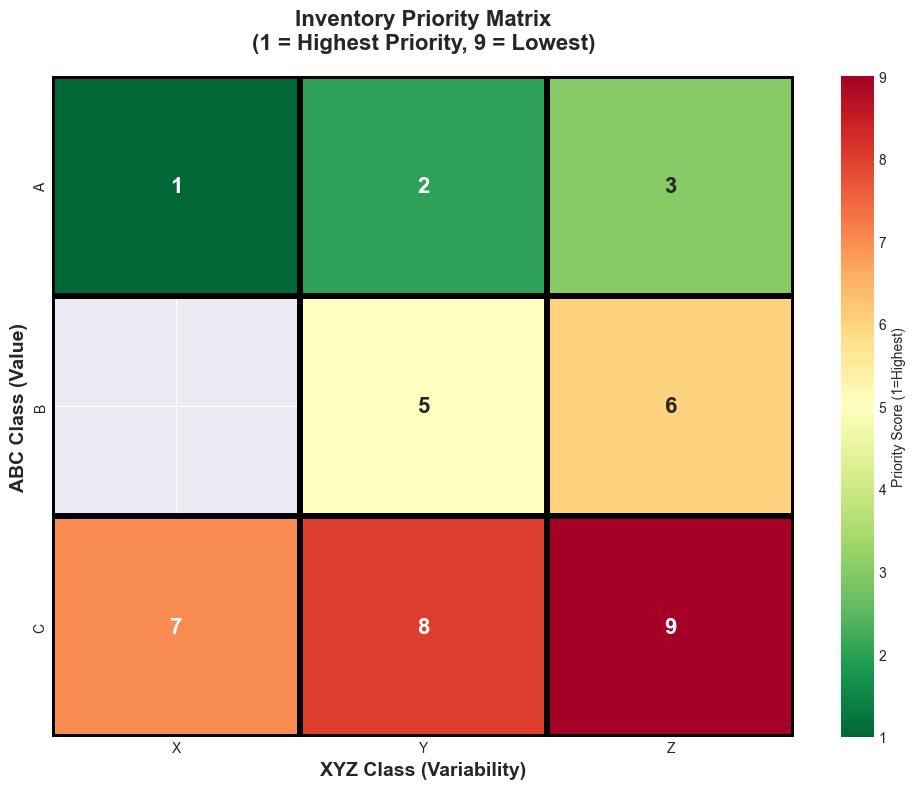

In [24]:
# Priority matrix visualization
priority_matrix = combined.groupby(['abc_class', 'xyz_class']).agg({
    'priority_score': 'first',
    'item_id': 'count',
    'revenue_sum': 'sum'
}).reset_index()

priority_pivot = priority_matrix.pivot(index='abc_class', columns='xyz_class', values='priority_score')

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(priority_pivot, annot=True, fmt='.0f', cmap='RdYlGn_r', ax=ax,
            cbar_kws={'label': 'Priority Score (1=Highest)'}, linewidths=3, linecolor='black',
            annot_kws={'fontsize': 16, 'fontweight': 'bold'})
ax.set_title('Inventory Priority Matrix\n(1 = Highest Priority, 9 = Lowest)', 
            fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('XYZ Class (Variability)', fontsize=14, fontweight='bold')
ax.set_ylabel('ABC Class (Value)', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 7. High-Priority Items Analysis

In [25]:
# Focus on critical items (priority 1-3)
critical_items = combined[combined['priority_score'] <= 3].sort_values('priority_score')

print(f"Critical Items (Priority 1-3): {len(critical_items)}")
print(f"Revenue contribution: ${critical_items['revenue_sum'].sum():,.2f} "
      f"({critical_items['revenue_sum'].sum() / combined['revenue_sum'].sum() * 100:.1f}%)")
print()

critical_items[['item_id', 'cat_id', 'revenue_sum', 'sales_mean', 'demand_cv', 
                'abc_xyz_class', 'priority_score']].head(20)

Critical Items (Priority 1-3): 1253
Revenue contribution: $5,020,149.18 (80.0%)



,item_id,cat_id,revenue_sum,sales_mean,demand_cv,abc_xyz_class,priority_score
840,FOODS_3_228,FOODS,5310.48,6.993363,0.495478,AX,1
989,FOODS_3_377,FOODS,7566.72,9.964602,0.432882,AX,1
1309,FOODS_3_697,FOODS,13194.00,9.730088,0.448401,AX,1
692,FOODS_3_080,FOODS,13372.80,17.610619,0.385104,AX,1
1167,FOODS_3_555,FOODS,14071.68,18.530973,0.373410,AX,1
676,FOODS_3_064,FOODS,14378.22,27.077434,0.391385,AX,1
1325,FOODS_3_714,FOODS,16834.90,23.573009,0.482789,AX,1
1089,FOODS_3_477,FOODS,4860.24,6.400442,0.466374,AX,1
711,FOODS_3_099,FOODS,20872.60,18.453540,0.378842,AX,1
234,FOODS_2_019,FOODS,23403.54,15.311947,0.441222,AX,1


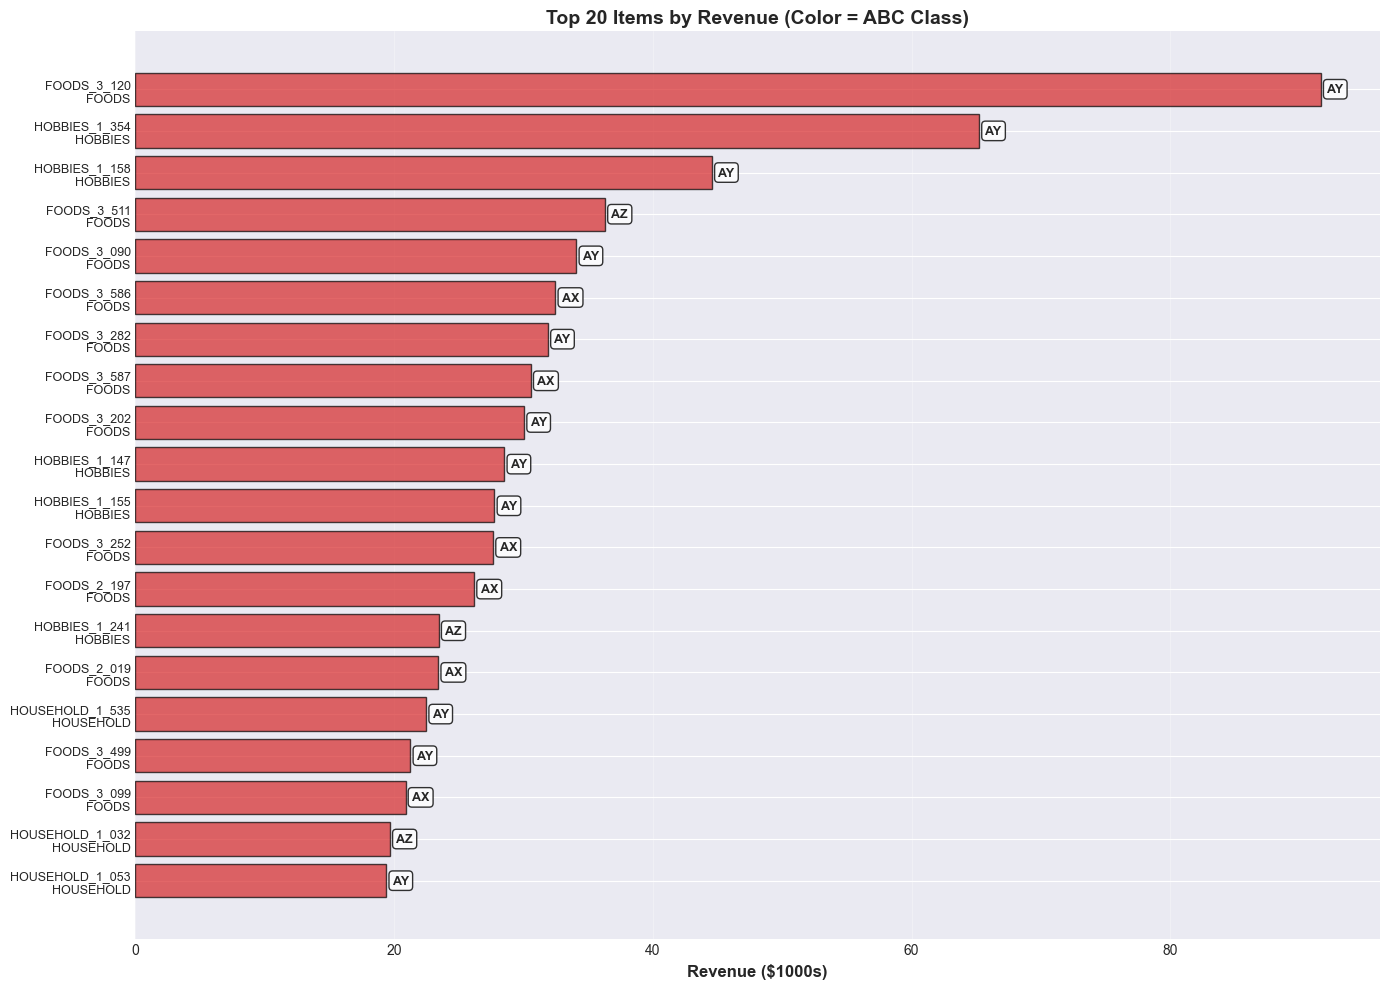

In [26]:
# Top 20 items by revenue with classification
top_20 = combined.nlargest(20, 'revenue_sum')

fig, ax = plt.subplots(figsize=(14, 10))

colors_map = {'A': '#d62728', 'B': '#ff7f0e', 'C': '#2ca02c'}
colors = [colors_map[cls] for cls in top_20['abc_class']]

y_pos = np.arange(len(top_20))
bars = ax.barh(y_pos, top_20['revenue_sum'] / 1000, color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(y_pos)
ax.set_yticklabels([f"{item}\n{cat}" for item, cat in zip(top_20['item_id'], top_20['cat_id'])], 
                   fontsize=9)
ax.set_xlabel('Revenue ($1000s)', fontsize=12, fontweight='bold')
ax.set_title('Top 20 Items by Revenue (Color = ABC Class)', fontsize=14, fontweight='bold')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

# Add ABC-XYZ class labels
for i, (bar, abc_xyz) in enumerate(zip(bars, top_20['abc_xyz_class'])):
    width = bar.get_width()
    ax.text(width + 0.5, bar.get_y() + bar.get_height()/2, abc_xyz,
           ha='left', va='center', fontweight='bold', fontsize=9,
           bbox=dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.8))

plt.tight_layout()
plt.show()

## 8. Key Insights and Summary

In [27]:
print("=" * 90)
print("KEY INSIGHTS FROM ABC-XYZ CLASSIFICATION")
print("=" * 90)
print()

print("📊 ABC Classification (Value):")
for cls in ['A', 'B', 'C']:
    count = len(combined[combined['abc_class'] == cls])
    revenue = combined[combined['abc_class'] == cls]['revenue_sum'].sum()
    revenue_pct = revenue / combined['revenue_sum'].sum() * 100
    print(f"  Class {cls}: {count} items ({count/len(combined)*100:.1f}%) = "
          f"${revenue:,.0f} ({revenue_pct:.1f}% of revenue)")

print()
print("📈 XYZ Classification (Variability):")
for cls in ['X', 'Y', 'Z']:
    count = len(combined[combined['xyz_class'] == cls])
    if count > 0:
        avg_cv = combined[combined['xyz_class'] == cls]['demand_cv'].mean()
        print(f"  Class {cls}: {count} items ({count/len(combined)*100:.1f}%) = "
              f"Avg CV: {avg_cv:.2f}")

print()
print("🎯 Critical Combinations:")
for cls in ['AX', 'AY', 'AZ', 'BX']:
    count = len(combined[combined['abc_xyz_class'] == cls])
    if count > 0:
        revenue = combined[combined['abc_xyz_class'] == cls]['revenue_sum'].sum()
        revenue_pct = revenue / combined['revenue_sum'].sum() * 100
        print(f"  {cls}: {count} items = ${revenue:,.0f} ({revenue_pct:.1f}% of revenue)")

print()
print("💡 Management Implications:")
print("  • Focus intensive monitoring on A-class items (high value)")
print("  • Z-class items need extra safety stock (high variability)")
print("  • AX items are ideal: high value + predictable demand")
print("  • AZ items need special attention: high value + volatile")
print()
print("✅ Ready for inventory optimization!")
print("=" * 90)

KEY INSIGHTS FROM ABC-XYZ CLASSIFICATION

📊 ABC Classification (Value):
  Class A: 1253 items (41.1%) = $5,020,149 (80.0% of revenue)
  Class B: 932 items (30.6%) = $941,421 (15.0% of revenue)
  Class C: 864 items (28.3%) = $314,434 (5.0% of revenue)

📈 XYZ Classification (Variability):
  Class X: 22 items (0.7%) = Avg CV: 0.37
  Class Y: 488 items (16.0%) = Avg CV: 0.83
  Class Z: 2539 items (83.3%) = Avg CV: 1.94

🎯 Critical Combinations:
  AX: 19 items = $288,491 (4.6% of revenue)
  AY: 462 items = $2,578,758 (41.1% of revenue)
  AZ: 772 items = $2,152,900 (34.3% of revenue)

💡 Management Implications:
  • Focus intensive monitoring on A-class items (high value)
  • Z-class items need extra safety stock (high variability)
  • AX items are ideal: high value + predictable demand
  • AZ items need special attention: high value + volatile

✅ Ready for inventory optimization!


## Next Steps

1. **Inventory Optimization**: Proceed to `03_inventory_optimization.ipynb`
2. Apply differentiated service levels based on ABC class
3. Calculate optimal inventory parameters (EOQ, safety stock, ROP)

In [28]:
# Save classified data
output_path = project_root / 'data/processed'
combined.to_csv(output_path / 'abc_xyz_classified_ca1.csv', index=False)
print(f"✅ Saved classified data to {output_path / 'abc_xyz_classified_ca1.csv'}")

✅ Saved classified data to /Users/godsonkurishinkal/Projects/data-science-portfolio/project-002-inventory-optimization-engine/data/processed/abc_xyz_classified_ca1.csv
